# Keras Upgrade

In [1]:
!pip install keras-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.2 MB/s eta 0:00:00


# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2024-10-23 05:08:21--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M  18.3MB/s    in 7.9s    

2024-10-23 05:08:30 (14.2 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import io

## Data Loading

In [3]:
data = io.loadmat('notMNIST_small.mat')

data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Aug 10 11:38:32 2011',
 '__version__': '1.0',
 '__globals__': [],
 'images': array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   1.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [255.,   0., 215., ...,   0., 160., 124.],
         [255.,   0., 227., ...,   0., 122.,  72.],
         [255.,   0., 156., ...,   0.,   0.,  12.]],
 
        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,  19.,   0., ...,   0.,   0.,   0.],
         [  0.,  93.,   0., ...,   0.,   0.,   0.],
         ...,
         [255.,   0., 255., ...,   0., 255., 255.],
         [255.,   0., 110., ...,   0., 206., 227.],
         [255.,   0.,  21., ...,   0.,   0.,  63.]],
 
        [[  0.,   3.,   0., ...,   0.,   0.,   0.],
         [  0., 167.,   0., ...,   0.,   0.,   0.],
         [  0., 255.,   0., ...,   1.,   1.,   0.],
         ...,
         [255.,   0., 223.

In [4]:
x = data['images']
y = data['labels']

In [5]:
x.shape, y.shape

((28, 28, 18724), (18724,))

In [6]:
resolution = 28
classes = 10

x = np.transpose(x, (2, 0, 1))
print(x.shape)
x = x.reshape( (-1, resolution, resolution, 1) )

(18724, 28, 28)


In [7]:
# sample, x, y, channel
x.shape, y.shape

((18724, 28, 28, 1), (18724,))

* 데이터 살펴보기

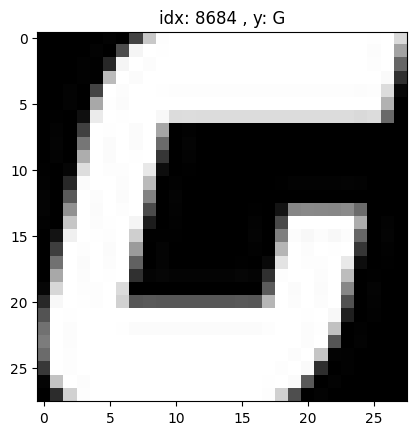

In [8]:
rand_i = np.random.randint(0, x.shape[0])

plt.title( f'idx: {rand_i} , y: {"ABCDEFGHIJ"[ int(y[rand_i]) ]}' )
plt.imshow( x[rand_i, :, :, 0], cmap='gray' )
plt.show()

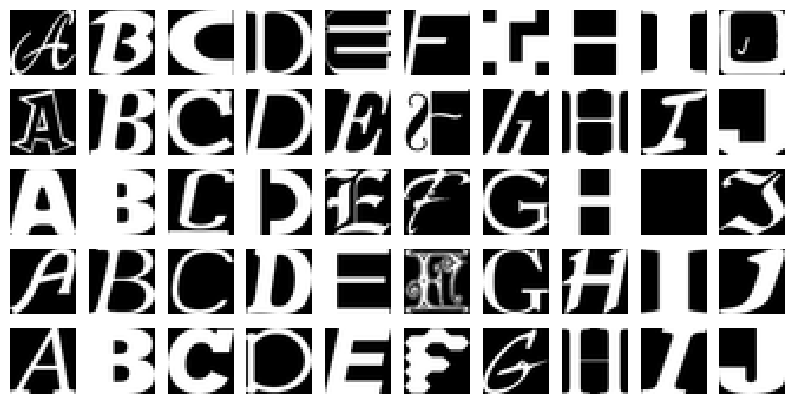

In [9]:
rows = 5
fig, axes = plt.subplots(rows, classes, figsize=(classes,rows))

for letter_id in range(classes) :
    letters = x[y==letter_id]      # 0부터 9까지 각 숫자에 맞는 array가 letters에 들어간다.
    letters_len = len(letters)

    for row_i in range(rows) :
        axe = axes[row_i, letter_id]
        axe.imshow( letters[np.random.randint(letters_len)], cmap='gray', interpolation='none')
        axe.axis('off')

## Data Preprocessing

* Data split

    - training set : test set = 8 : 2
    - 재현을 위한 난수 고정 : 2024

In [10]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=2024)

In [11]:
train_x.shape, train_y.shape

((14979, 28, 28, 1), (14979,))

* Scaling

    - min-max scaling

In [12]:
# train_x_ss = train_x / 255.0
# test_x_ss = test_x / 255.0

In [13]:
max, min = train_x.max(), train_x.min()

train_x_ss = (train_x - min) / (max - min)
test_x_ss = (test_x - min) / (max - min)

In [14]:
train_x_ss.min(), train_x_ss.max()

(0.0, 1.0)

* One-hot encoding

In [15]:
from keras.utils import to_categorical

class_n = len(np.unique(train_y))

train_y_hot = to_categorical(train_y, class_n)
test_y_hot = to_categorical(test_y, class_n)

* Data shape 재확인

In [16]:
train_x_ss.shape, train_y_hot.shape

((14979, 28, 28, 1), (14979, 10))

## Modeling : CNN

- 조건
    1. Sequential API, Functiona API 중 택일.
    2. [이 구조를 미니 버전으로 활용해봐도 좋다.](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
    3. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.
    4. Early Stopping을 사용할 것.

In [17]:
from keras.utils import clear_session, plot_model
from keras.models import Sequential, Model
from keras.layers import Flatten, Input, Dense, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import EarlyStopping

* Sequential API

In [54]:
clear_session()


# model_cnn = Sequential([Input(shape=(28,28,1)),
#                Conv2D(filters=64,           # 새롭게 feature map의 수 or 서로 다른 conv filter 64개 사용
#                       kernel_size = (3,3),     # filter의 크기
#                       strides=(1,1),        # filter의 움직임
#                       padding='same',       # feature map 사이즈 유지
#                       activation='relu'),
#                 Conv2D(filters=64,          # 새롭게 feature map의 수 or 서로 다른 conv filter 64개 사용
#                       kernel_size = (3,3),     # filter의 크기
#                       strides=(1,1),        # filter의 움직임
#                       padding='same',       # feature map 사이즈 유지
#                       activation='relu'),
#                MaxPool2D(pool_size=(2,2),   # pooling filter의 크기
#                          strides=(2,2)),    # filter의 움직임
#                Conv2D(filters=128,           # 새롭게 feature map의 수 or 서로 다른 conv filter 64개 사용
#                       kernel_size = (3,3),     # filter의 크기
#                       strides=(1,1),        # filter의 움직임
#                       padding='same',       # feature map 사이즈 유지
#                       activation='relu'),
#                 Conv2D(filters=128,          # 새롭게 feature map의 수 or 서로 다른 conv filter 64개 사용
#                       kernel_size = (3,3),     # filter의 크기
#                       strides=(1,1),        # filter의 움직임
#                       padding='same',       # feature map 사이즈 유지
#                       activation='relu'),
#                MaxPool2D(pool_size=(2,2),   # pooling filter의 크기
#                          strides=(2,2)),    # filter의 움직임
#                Flatten(),
#                Dense(1024, activation='relu'),
#                Dense(10, activation='softmax')
#                ])
# model_cnn.summary()


model_cnn = Sequential()
model_cnn.add( Input(shape=(28,28,1)))
model_cnn.add( Conv2D(64, (3, 3), (1,1), padding='same', activation='relu',) )
model_cnn.add( Conv2D(64, (3, 3), (1,1), padding='same', activation='relu',) )
model_cnn.add( MaxPool2D((2,2),(2,2),))
model_cnn.add( BatchNormalization() )
model_cnn.add( Dropout(0.25) )

model_cnn.add( Conv2D(128, (3, 3), (1,1), padding='same', activation='relu',) )
model_cnn.add( Conv2D(128, (3, 3), (1,1), padding='same', activation='relu',) )
model_cnn.add( BatchNormalization() )
model_cnn.add( MaxPool2D((2,2),(2,2),))
model_cnn.add( Dropout(0.25) )

model_cnn.add( Conv2D(256, (3, 3), (1,1), padding='same', activation='relu',) )
model_cnn.add( Conv2D(256, (3, 3), (1,1), padding='same', activation='relu',) )
model_cnn.add( BatchNormalization() )
model_cnn.add( MaxPool2D((2,2),(2,2),))
model_cnn.add( Dropout(0.25) )

model_cnn.add( Flatten() )
model_cnn.add( Dense(4096, activation='relu') )
model_cnn.add( Dense(4096, activation='relu') )
model_cnn.add( Dense(class_n, activation='softmax') )
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       9,441,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,409,610 (104.56 MB)

 Trainable params: 27,408,714 (104.56 MB)

 Non-trainable params: 896 (3.50 KB)

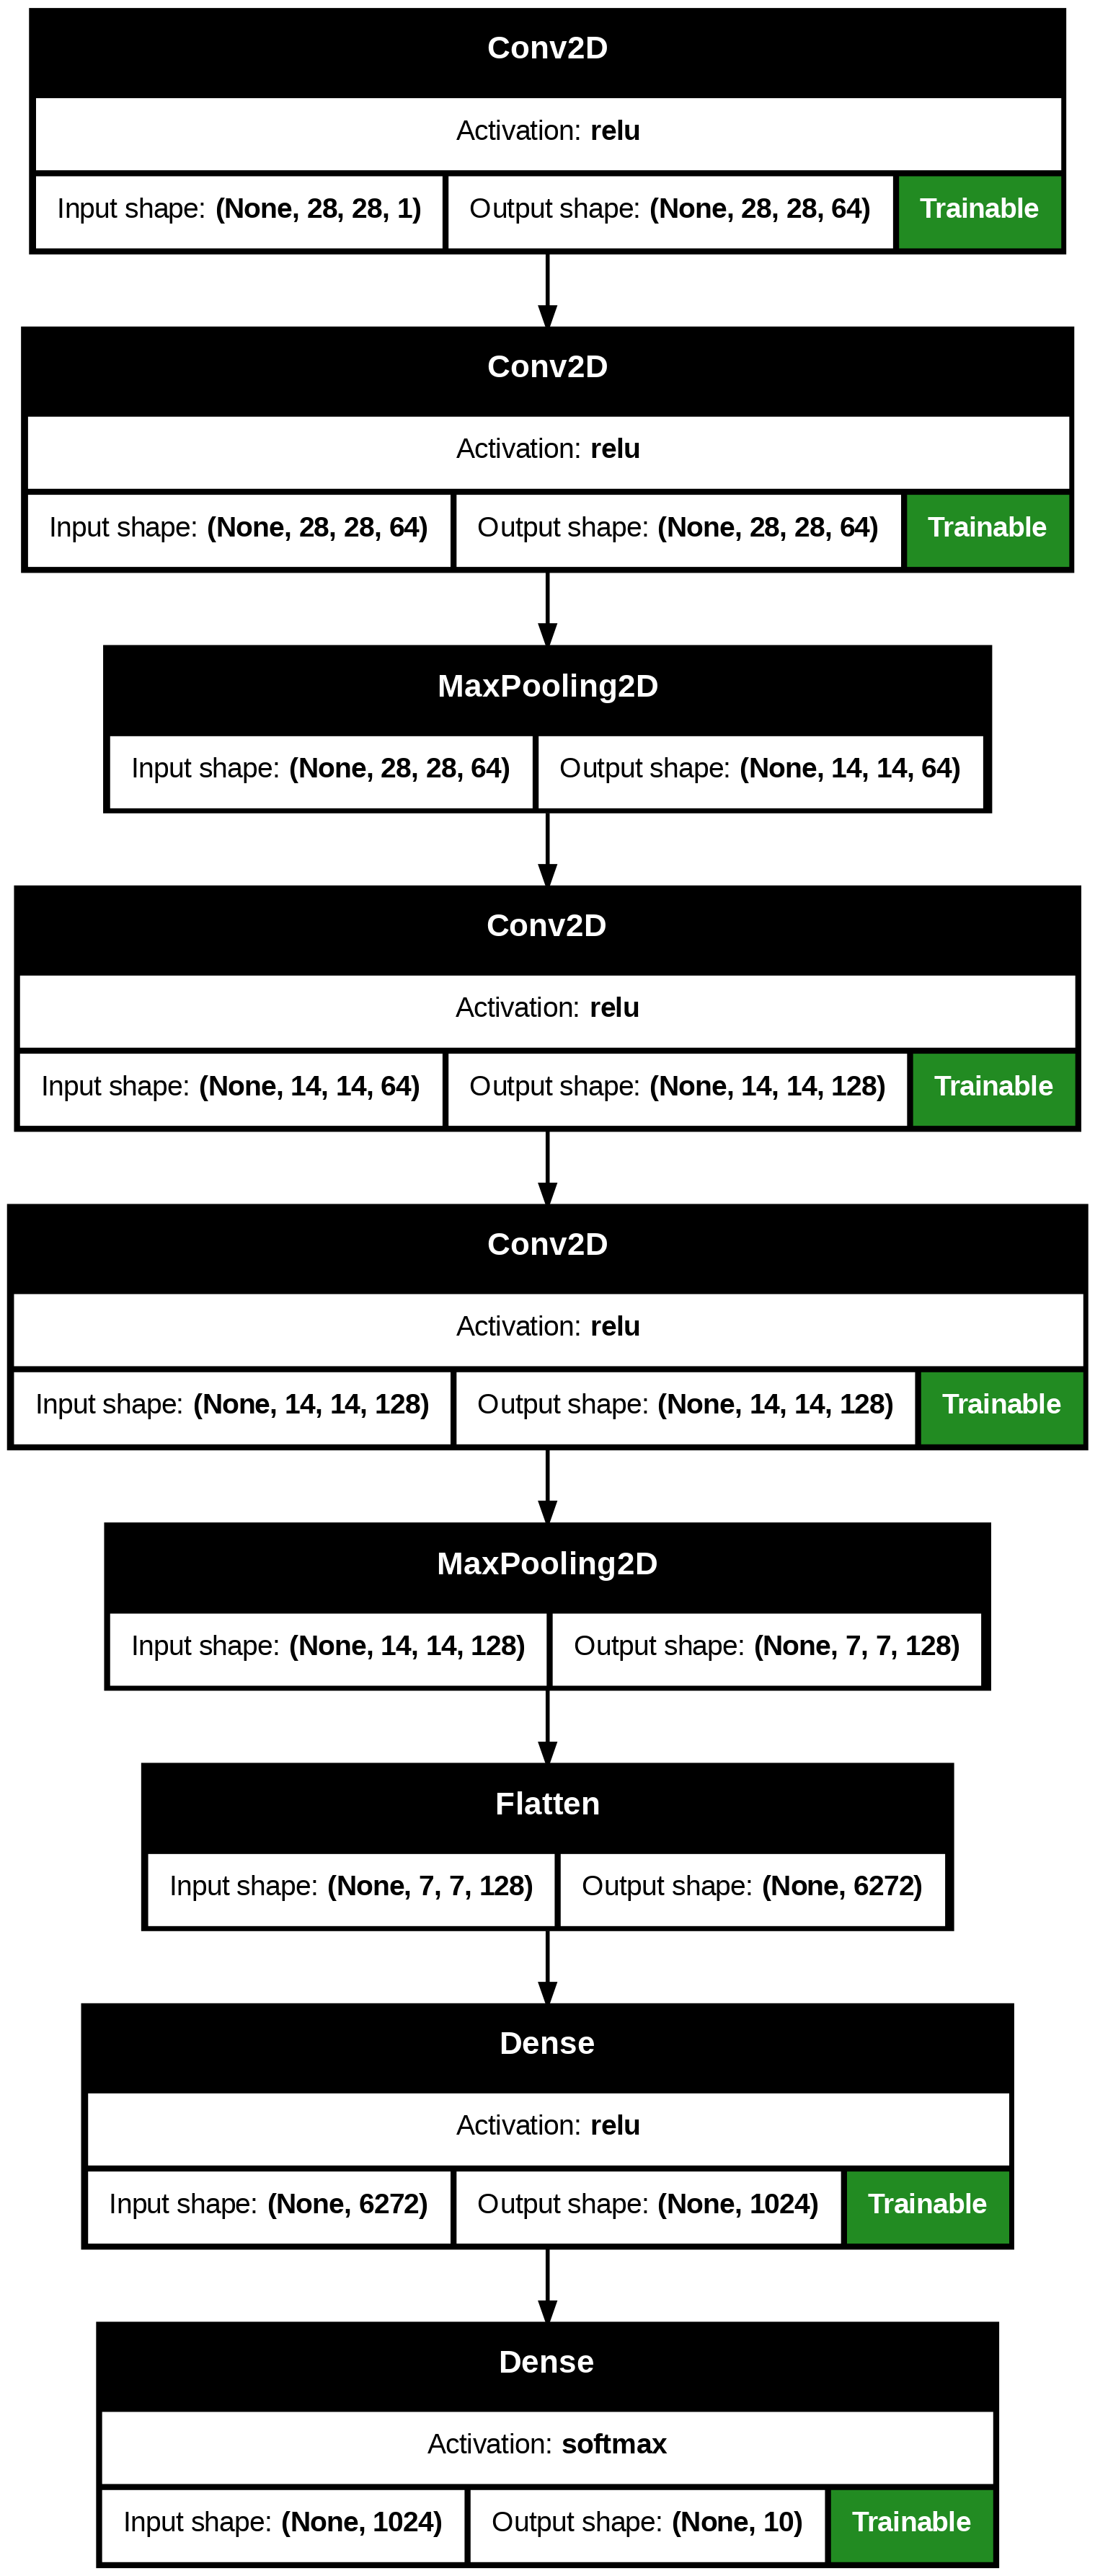

In [19]:
plot_model(model_cnn,
           show_shapes=True,
           show_layer_activations=True,
           show_trainable=True,
           )

* Functional API

In [60]:
clear_session()

il = Input(shape=(28,28,1), name='notMNIST_Input')
hl = Conv2D(64, 3, 1, 'same', activation='relu', name='notMNIST_Conv1')(il)
hl = Conv2D(64, 3, 1, 'same', activation='relu', name='notMNIST_Conv2')(hl)
hl = MaxPool2D(2,2)(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.25)(hl)

hl = Conv2D(128, (3, 3), (1,1), padding='same', activation='relu',)(hl)
hl = Conv2D(128, (3, 3), (1,1), padding='same', activation='relu',)(hl)
hl = MaxPool2D((2,2),(2,2),)(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.25)(hl)

hl = Conv2D(256, (3, 3), (1,1), padding='same', activation='relu',)(hl)
hl = Conv2D(256, (3, 3), (1,1), padding='same', activation='relu',)(hl)
hl = MaxPool2D((2,2),(2,2),)(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.25)(hl)

hl = Flatten()(hl)
hl = Dense(4096, activation='relu')(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.25)(hl)
hl = Dense(4096, activation='relu')(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.25)(hl)
lo = Dense(class_n, activation='softmax')(hl)

model_cnn = Model(inputs=il, outputs=lo)

model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ notMNIST_Input (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ notMNIST_Conv1 (Conv2D)              │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ notMNIST_Conv2 (Conv2D)              │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       9,441,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,442,378 (104.68 MB)

 Trainable params: 27,425,098 (104.62 MB)

 Non-trainable params: 17,280 (67.50 KB)

In [21]:
## 1. 세션 클리어
clear_session()

## 2. 레이어 엮기
il = Input(shape=(28,28,1), name='notMNIST_Input')
hl = Conv2D(64, 3, 1, 'same', activation='relu', name='notMNIST_Conv1')(il)
hl = Conv2D(64, 3, 1, 'same', activation='relu', name='notMNIST_Conv2')(hl)
hl = MaxPool2D(2, 2, name='notMNIST_Maxpool1')(hl)
hl = Conv2D(128, 3, 1, 'same', activation='relu', name='notMNIST_Conv3')(hl)
hl = Conv2D(128, 3, 1, 'same', activation='relu', name='notMNIST_Conv4')(hl)
hl = MaxPool2D(2, 2, name='notMNIST_Maxpool2')(hl)

hl = Flatten(name='notMNIST_Flatten')(hl)
hl = Dense(1024, activation='relu', name='FC_1')(hl)
ol = Dense(10, activation='softmax', name='notMNIST_Output')(hl)

## 3. 모델의 시작과 끝 지정
model_cnn = Model(il, ol)

## 요약
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ notMNIST_Input (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ notMNIST_Conv1 (Conv2D)              │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ notMNIST_Conv2 (Conv2D)              │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ notMNIST_Maxpool1 (MaxPooling2D)     │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ notMNIST_Conv3 (Conv2D)              │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ notMNIST_Conv4 (Conv2D)              │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ notMNIST_Maxpool2 (MaxPooling2D)     │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ notMNIST_Flatten (Flatten)           │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_1 (Dense)                         │ (None, 1024)                │       6,423,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ notMNIST_Output (Dense)              │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,692,810 (25.53 MB)

 Trainable params: 6,692,810 (25.53 MB)

 Non-trainable params: 0 (0.00 B)

- compile

In [61]:
model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                  )

* Early Stopping

In [62]:
es = EarlyStopping(monitor = 'val_loss',        # 얼리스토핑의 기준(val_accuracy도 가능)
                   min_delta=0,                 # 임계값보다 크게 변화해야 개선
                   patience=5,                  # 성능 개선이 발생하지 않을 때, 몇 epoch 더 볼 것인가
                   verbose=1,
                   restore_best_weights=True,)  # 학습이 멈췄을 때, 최적 가중치 epoch 시점으로 되돌림

* .fit( )

In [63]:
history = model_cnn.fit(train_x_ss, train_y_hot, validation_split=0.2, epochs=10000, callbacks=[es] )

Epoch 1/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.7670 - loss: 1.5767 - val_accuracy: 0.8328 - val_loss: 0.5309
Epoch 2/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8931 - loss: 0.4500 - val_accuracy: 0.9252 - val_loss: 0.2922
Epoch 3/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9222 - loss: 0.3037 - val_accuracy: 0.9232 - val_loss: 0.4163
Epoch 4/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9284 - loss: 0.2730 - val_accuracy: 0.9256 - val_loss: 0.3177
Epoch 5/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9281 - loss: 0.2732 - val_accuracy: 0.9339 - val_loss: 0.2831
Epoch 6/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9454 - loss: 0.2024 - val_accuracy: 0.9383 - val_loss: 0.2583
Epoch 7/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9437 - loss: 0.1947 - val_accuracy: 0.9262 - val_loss: 0.3009
Epoch 8/10000
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.939

* .evaluate( )

In [64]:
performance_test = model_cnn.evaluate(test_x_ss, test_y_hot)

print( f'Test Loss : {performance_test[0]:.6f}, Test Accuracy : {performance_test[1]*100:.3f}%' )

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9578 - loss: 0.1608
Test Loss : 0.188789, Test Accuracy : 95.327%


* .predict( )

In [66]:
y_pred = model_cnn.predict(test_x_ss)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [67]:
# 원핫 인코딩 한 것을 다시 묶어주는 코드
# 평가 지표 및 실제 데이터 확인을 위해 필요

y_pred_arg = np.argmax(y_pred, axis=1)
test_y_arg = np.argmax(test_y_hot, axis=1)

* 평가 지표

In [68]:
from sklearn.metrics import accuracy_score, classification_report

In [69]:
accuracy_score(test_y_arg, y_pred_arg)

0.9532710280373832

In [70]:
class_names = ['A','B','C','D','E','F','G','H','I','J']

print( classification_report(test_y_arg, y_pred_arg, target_names=class_names) )

              precision    recall  f1-score   support

           A       0.98      0.92      0.95       360
           B       0.95      0.97      0.96       382
           C       0.96      0.95      0.96       385
           D       0.95      0.97      0.96       373
           E       0.93      0.98      0.95       364
           F       0.94      0.98      0.96       392
           G       0.97      0.93      0.95       390
           H       0.97      0.96      0.97       364
           I       0.91      0.92      0.92       360
           J       0.96      0.95      0.96       375

    accuracy                           0.95      3745
   macro avg       0.95      0.95      0.95      3745
weighted avg       0.95      0.95      0.95      3745



## Visualization

* 실제 데이터 확인

idx = 1741
해당 인덱스의 이미지는 C
모델의 예측 : C
모델의 클래스별 확률 : 
-------------------
A 0.0
B 0.0
C 99.0
D 0.0
E 0.0
F 0.0
G 0.0
H 0.0
I 0.0
J 0.0
정답


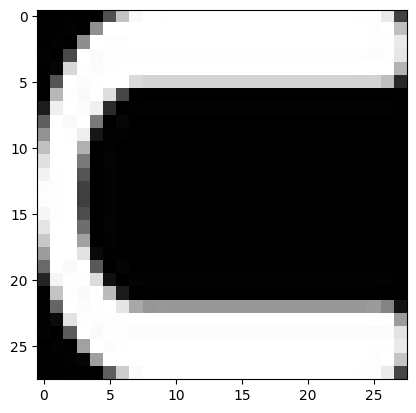

In [71]:
letters_str = "ABCDEFGHIJ"

rand_idx = np.random.randint(0, len(y_pred_arg))
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(test_x[rand_idx], cmap='gray')
plt.show()

* 틀린 이미지만 확인해보기

In [72]:
temp = (test_y_arg == y_pred_arg)
false_idx = np.where(temp==False)[0]
false_len = len(false_idx)
false_len

175

idx = 3481
해당 인덱스의 이미지는 I
모델의 예측 : J
모델의 클래스별 확률 : 
-------------------
A 0.0
B 0.0
C 0.0
D 1.0
E 0.0
F 0.0
G 0.0
H 0.0
I 22.0
J 74.0
땡


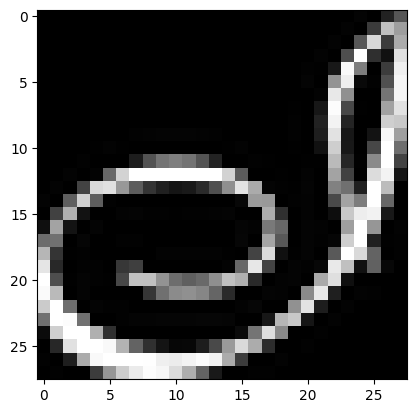

In [73]:
letters_str = "ABCDEFGHIJ"

rand_idx = false_idx[np.random.randint(0, false_len)]
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(test_x[rand_idx], cmap='gray')
plt.show()